In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
%matplotlib inline
np.random.seed(0)

## Data Construction

We simulated a binary dataset consisting of a 1000 data points, the dataset follows a simple linear function $f(x)=mx + c$ where the x is generated randomly from a uniform distribution between $0$ and $1$ and a corresponding y value is calculated with added gaussian noise of mean $\mu=0$ and standard deviation $\sigma=0.25$. Since this dataset is simulated probabilistically by construction the X value of each data point is the probability of that point belonging to class 1.

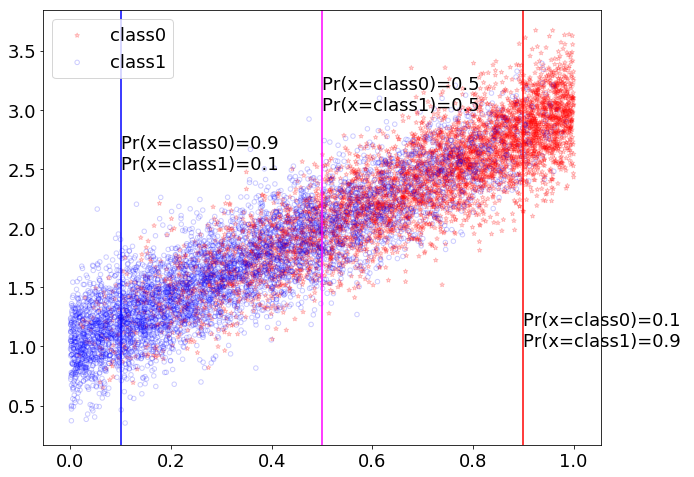

In [2]:
def f(x):
    return 2*x + 1

x=np.random.uniform(0,1,10000)


x0 = []
y0 = []

x1 = []
y1 = []

Y1=np.zeros(len(x))

X1=np.zeros((len(x),2))


for i in range(len(x)):

    
    if np.random.random() < x[i]:
        x0.append(x[i])
        y0.append( f(x[i]) + np.random.normal(0,0.25)  )

        
    else:
        x1.append(x[i])
        y1.append( f(x[i]) + np.random.normal(0,0.25) ) 
    

plt.rcParams.update({'font.size': 18})
        
plt.figure(figsize=(10,8))
plt.scatter(x0,y0,marker='*',s=20,facecolors='none',edgecolors='r',alpha=0.3,label='class0')
plt.scatter(x1,y1,marker='o',s=20,facecolors='none',edgecolors='b',alpha=0.2,label='class1') # class 1
plt.axvline(0.1,color='blue')
plt.axvline(0.5,color='magenta')
plt.axvline(0.9,color='red')
plt.text(0.1,2.5,s='Pr(x=class0)=0.9 ' + '\n' + 'Pr(x=class1)=0.1 ' )
plt.text(0.5,3,s='Pr(x=class0)=0.5 ' + '\n' + 'Pr(x=class1)=0.5 ' )
plt.text(0.9,1,s='Pr(x=class0)=0.1 ' + '\n' + 'Pr(x=class1)=0.9 ' )
plt.legend()
plt.savefig('simulated.png')
plt.show()




## Rescaling, reshaping and splitting the data for use in the neural network in training and testting

In [3]:
Y1=np.zeros(len(x0))
Y2=np.ones(len(x1))

Y=np.concatenate((Y1, Y2), axis=0)

x=np.concatenate((x0, x1), axis=0)
y=np.concatenate((y0, y1), axis=0)

X=np.stack((x, y), axis=-1)


X = np.asarray(X)
Y = np.asarray(Y)

#X = scale(X)
X = X.astype(float)
Y = Y.astype(float)

X.shape , Y.shape

((10000, 2), (10000,))

## Building a neural betwork using a multi-layer perceptron from SKlearn called the MLPClassifier

Network architecture :
- input layer with 2 neurons
- 2 hidden layers with 5 neurons
- 1 output layer (softmax)

<img src="architecture.png">


We look to observe the reliability curve of the MLPClassifier

In [5]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
%matplotlib inline

In [22]:
def reliability_curve(y_true, y_score, bins=10, normalize=False):
    """Compute reliability curve

    Reliability curves allow checking if the predicted probabilities of a
    binary classifier are well calibrated. This function returns two arrays
    which encode a mapping from predicted probability to empirical probability.
    For this, the predicted probabilities are partitioned into equally sized
    bins and the mean predicted probability and the mean empirical probabilties
    in the bins are computed. For perfectly calibrated predictions, both
    quantities whould be approximately equal (for sufficiently many test
    samples).

    Note: this implementation is restricted to binary classification.

    Parameters
    ----------

    y_true : array, shape = [n_samples]
        True binary labels (0 or 1).

    y_score : array, shape = [n_samples]
        Target scores, can either be probability estimates of the positive
        class or confidence values. If normalize is False, y_score must be in
        the interval [0, 1]

    bins : int, optional, default=10
        The number of bins into which the y_scores are partitioned.
        Note: n_samples should be considerably larger than bins such that
              there is sufficient data in each bin to get a reliable estimate
              of the reliability

    normalize : bool, optional, default=False
        Whether y_score needs to be normalized into the bin [0, 1]. If True,
        the smallest value in y_score is mapped onto 0 and the largest one
        onto 1.


    Returns
    -------
    y_score_bin_mean : array, shape = [bins]
        The mean predicted y_score in the respective bins.

    empirical_prob_pos : array, shape = [bins]
        The empirical probability (frequency) of the positive class (+1) in the
        respective bins.


    References
    ----------
    .. [1] `Predicting Good Probabilities with Supervised Learning
            <http://machinelearning.wustl.edu/mlpapers/paper_files/icml2005_Niculescu-MizilC05.pdf>`_

    """
    if normalize:  # Normalize scores into bin [0, 1]
        y_score = (y_score - y_score.min()) / (y_score.max() - y_score.min())

    bin_width = 1.0 / bins
    bin_centers = np.linspace(0, 1.0 - bin_width, bins) + bin_width / 2

    y_score_bin_mean = np.empty(bins)
    empirical_prob_pos = np.empty(bins)
    for i, threshold in enumerate(bin_centers):
        # determine all samples where y_score falls into the i-th bin
        bin_idx = np.logical_and(threshold - bin_width / 2 < y_score,
                                 y_score <= threshold + bin_width / 2)
        # Store mean y_score and mean empirical probability of positive class
        y_score_bin_mean[i] = y_score[bin_idx].mean()
        empirical_prob_pos[i] = y_true[bin_idx].mean()
    return y_score_bin_mean, empirical_prob_pos

In [23]:
reliability_scores = {}
y_score = {}
predicted_lists=[]
prednan=[]
for i in range(25):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.25, shuffle=True)
    scaler = StandardScaler()
    scaler.fit(X_train)


    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    clf = MLPClassifier(solver='sgd',alpha=1e-5,hidden_layer_sizes=(5,5),random_state=1)

    clf.fit(X_train,Y_train)
    
    
    y_score['MLP classifier'] = clf.predict_proba(X_test)[:,1]
    reliability_scores['MLP classifier']=\
    reliability_curve(Y_test , y_score['MLP classifier'], bins=25 , normalize=False)
    
    
    arr=reliability_scores['MLP classifier'][0]
    scores_not_nan = np.logical_not(np.isnan(arr))
    predic_notnan=arr[scores_not_nan]
    prednan.append(arr)
    predicted_lists.append(predic_notnan)




/usr/lib/python3/dist-packages/ipykernel/__main__.py:67: RuntimeWarning: Mean of empty slice.
/home/tumisang/.local/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/lib/python3/dist-packages/ipykernel/__main__.py:68: RuntimeWarning: Mean of empty slice.
/usr/lib/python3/dist-packages/ipykernel/__main__.py:67: RuntimeWarning: Mean of empty slice.
/home/tumisang/.local/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/lib/python3/dist-packages/ipykernel/__main__.py:68: RuntimeWarning: Mean of empty slice.
/usr/lib/python3/dist-packages/ipykernel/__main__.py:67: RuntimeWarning: Mean of empty slice.
/home/tumisang/.local/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/lib

In [94]:
import pandas as pd
stderrors=[]
for i in range(len(prednan)):
    place=[]
    place=[t[i] for t in prednan]
    DF=pd.DataFrame({'vals':place})

    DF.dropna(inplace=True)
   
    stderrors.append(np.std(DF['vals'].values))
YERR=np.asarray(stderrors)

/home/tumisang/.local/lib/python3.5/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/tumisang/.local/lib/python3.5/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/tumisang/.local/lib/python3.5/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [95]:
YERR

array([       nan,        nan, 0.00220125, 0.00067039, 0.00089235,
       0.00082339, 0.0009847 , 0.00122236, 0.00090857, 0.00106452,
       0.00092005, 0.00138203, 0.00116445, 0.00143317, 0.00105832,
       0.00131783, 0.00100562, 0.00088537, 0.00089853, 0.00123377,
       0.00092965, 0.00073487, 0.0006715 , 0.00113574, 0.00085148])

In [65]:
'''import pandas as pd
stderrors=[]
for i in range(len(prednan)):
    place=[]
    place=[t[i] for t in prednan]
    std_hold=np.std(place)
    stderrors.append(std_hold)
'''


'import pandas as pd\nstderrors=[]\nfor i in range(len(prednan)):\n    place=[]\n    place=[t[i] for t in prednan]\n    std_hold=np.std(place)\n    stderrors.append(std_hold)\n'

In [91]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.25)
scaler = StandardScaler()
scaler.fit(X_train)


X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

bins=25

reliability_scores = {}
y_score = {}
clf = MLPClassifier(solver='sgd',alpha=1e-5,hidden_layer_sizes=(5,5),random_state=1)


clf.fit(X_train,Y_train)
pred=clf.predict(X_test)


y_score['MLP classifier'] = clf.predict_proba(X_test)[:,1]
reliability_scores['MLP classifier']=\
reliability_curve(Y_test , y_score['MLP classifier'], bins=bins , normalize=False)



/usr/lib/python3/dist-packages/ipykernel/__main__.py:67: RuntimeWarning: Mean of empty slice.
/home/tumisang/.local/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/lib/python3/dist-packages/ipykernel/__main__.py:68: RuntimeWarning: Mean of empty slice.


	Accuracy: 0.744
	Precision: 0.747
	Recall: 0.735
	F1: 0.741



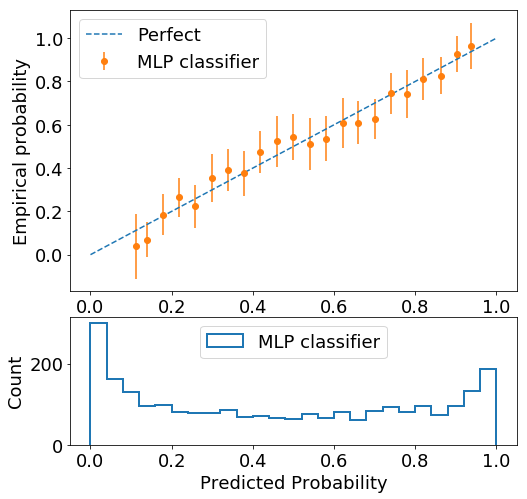

In [92]:
plt.figure(0, figsize=(8, 8))
plt.rcParams.update({'font.size': 18})
plt.subplot2grid((3, 1), (0, 0), rowspan=2)
plt.plot([0.0, 1.0], [0.0, 1.0] ,'--', label="Perfect")
for method, (y_score_bin_mean, empirical_prob_pos) in reliability_scores.items():
    scores_not_nan = np.logical_not(np.isnan(empirical_prob_pos))
    
    plt.errorbar(y_score_bin_mean[scores_not_nan],
             empirical_prob_pos[scores_not_nan], yerr=YERR[scores_not_nan] ,fmt='o',label=method)
plt.ylabel("Empirical probability")
plt.legend(loc=0)

plt.subplot2grid((3, 1), (2, 0))
for method, y_score_ in y_score.items():
    
    y_score_ = (y_score_ - y_score_.min()) / (y_score_.max() - y_score_.min())
    plt.hist(y_score_, range=(0, 1), bins=bins ,label=method,
             histtype="step", lw=2)
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.savefig('reliabilityMLP.png')
plt.legend(loc='upper center', ncol=2)


print("\tAccuracy: %1.3f"%clf.score(X_test, Y_test))
print("\tPrecision: %1.3f" % precision_score(Y_test, pred))
print("\tRecall: %1.3f" % recall_score(Y_test, pred))
print("\tF1: %1.3f\n" % f1_score(Y_test, pred))

	Accuracy: 0.744
	Precision: 0.747
	Recall: 0.735
	F1: 0.741



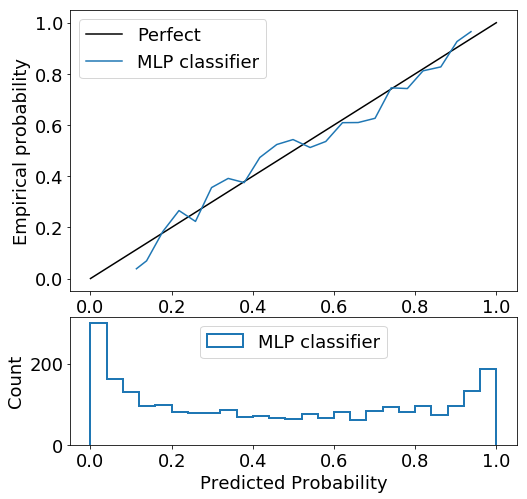

In [96]:
plt.figure(0, figsize=(8, 8))
plt.rcParams.update({'font.size': 18})
plt.subplot2grid((3, 1), (0, 0), rowspan=2)
plt.plot([0.0, 1.0], [0.0, 1.0],'k', label="Perfect")
for method, (y_score_bin_mean, empirical_prob_pos) in reliability_scores.items():
    scores_not_nan = np.logical_not(np.isnan(empirical_prob_pos))
    plt.plot(y_score_bin_mean[scores_not_nan],
             empirical_prob_pos[scores_not_nan], label=method)
plt.ylabel("Empirical probability")
plt.legend(loc=0)

plt.subplot2grid((3, 1), (2, 0))
for method, y_score_ in y_score.items():
    y_score_ = (y_score_ - y_score_.min()) / (y_score_.max() - y_score_.min())
    plt.hist(y_score_, range=(0, 1), bins=bins, label=method,
             histtype="step", lw=2)
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.savefig('reliabilityMLP.png')
plt.legend(loc='upper center', ncol=2)


print("\tAccuracy: %1.3f"%clf.score(X_test, Y_test))
print("\tPrecision: %1.3f" % precision_score(Y_test, pred))
print("\tRecall: %1.3f" % recall_score(Y_test, pred))
print("\tF1: %1.3f\n" % f1_score(Y_test, pred))

## Now we make the plot where we compare our x vaules which by construction is our real probabilities of any point belonging to class 1 to the predicted probabilities


In [12]:
Pred_prob=clf.predict_proba(X_test)

X_true=scaler.inverse_transform(X_test, copy=None)

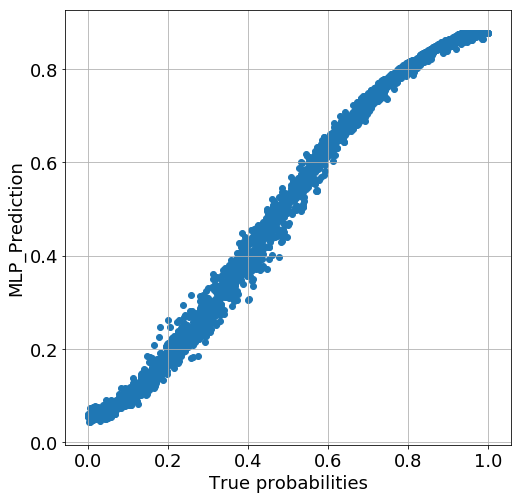

In [13]:
plt.figure(figsize=(8,8))
plt.rcParams.update({'font.size': 18})
plt.scatter(X_true[:,0],Pred_prob[:,0])
plt.ylabel('MLP_Prediction')
plt.xlabel('True probabilities')
plt.grid()
plt.savefig('predbMLP.png')
plt.show()

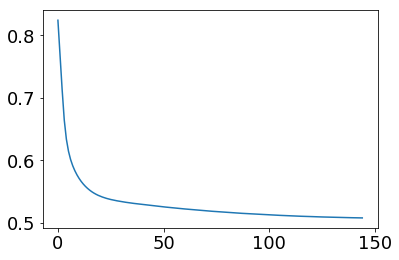

In [14]:
plt.plot(clf.loss_curve_)
plt.show()

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test,pred)

array([[960, 290],
       [325, 925]])

In [16]:
confusion_matrix(Y_test,pred)

array([[960, 290],
       [325, 925]])